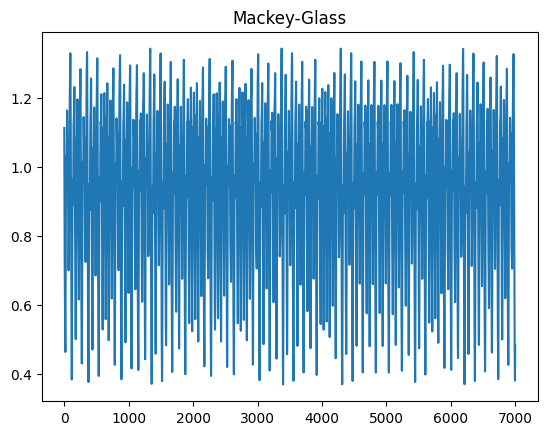

Train: 4000
Val  : 1500
Test : 1500


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 60, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.5749 - mae: 0.5934 - val_loss: 0.0362 - val_mae: 0.1574 - learning_rate: 0.0010
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0308 - mae: 0.1454 - val_loss: 0.0168 - val_mae: 0.1075 - learning_rate: 0.0010
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0132 - mae: 0.0947 - val_loss: 0.0049 - val_mae: 0.0568 - learning_rate: 0.0010
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0040 - mae: 0.0511 - val_loss: 0.0015 - val_mae: 0.0315 - learning_rate: 0.0010
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0015 - mae: 0.0317 - val_loss: 9.4700e-04 - val_mae: 0.0243 - learning_rate: 0.0010
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0012 - mae: 0.0275 - val_loss: 7.4792e-04 - val_mae: 0.0216 - learning_rate: 0.0010
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 9.2804e-04 - mae: 0.0244 - val_loss: 6.1946e-04 - val_mae: 0.0196 - learning_rate:

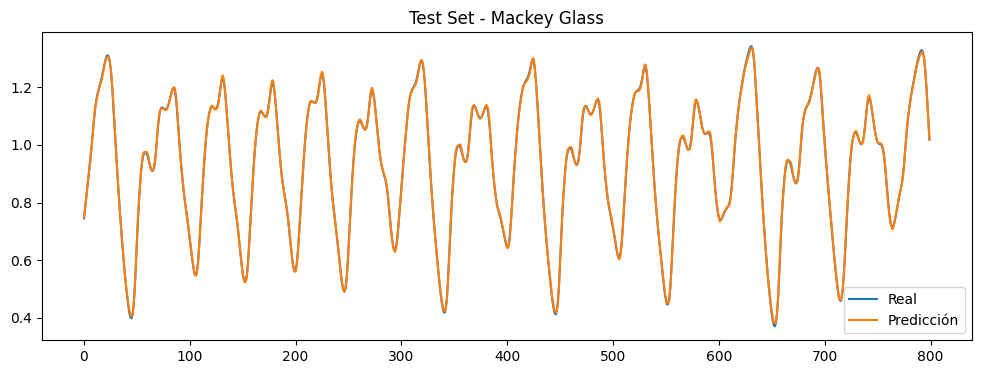

In [3]:
# ==========================================
# Mackey-Glass + GRU con Train/Val/Test
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# -----------------------------
# 1) Mackey-Glass
# -----------------------------
def mackey_glass(n_steps=7000, tau=17, beta=0.2, gamma=0.1, n=10):
    tau = int(tau)
    x = np.zeros(n_steps + tau + 1)
    x[:tau+1] = 1.2

    for t in range(tau, n_steps + tau):
        x[t+1] = x[t] + (
            beta * x[t - tau] / (1 + x[t - tau]**n)
            - gamma * x[t]
        )
    return x[tau+1:]

series = mackey_glass()

plt.plot(series)
plt.title("Mackey-Glass")
plt.show()

# -----------------------------
# 2) División temporal
# -----------------------------
N = len(series)

train_end = 4000
val_end   = 5500

train_series = series[:train_end]
val_series   = series[train_end:val_end]
test_series  = series[val_end:]

print("Train:", len(train_series))
print("Val  :", len(val_series))
print("Test :", len(test_series))

# -----------------------------
# 3) Normalización (solo con train)
# -----------------------------
mean = train_series.mean()
std  = train_series.std() + 1e-8

train_series = (train_series - mean)/std
val_series   = (val_series - mean)/std
test_series  = (test_series - mean)/std

# -----------------------------
# 4) Ventanas
# -----------------------------
def make_windows(data, lookback=60):
    X, y = [], []
    for i in range(len(data)-lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X)[...,None], np.array(y)[...,None]

LOOKBACK = 60

X_train, y_train = make_windows(train_series, LOOKBACK)
X_val, y_val     = make_windows(val_series, LOOKBACK)
X_test, y_test   = make_windows(test_series, LOOKBACK)

# -----------------------------
# 5) Modelo GRU
# -----------------------------
model = models.Sequential([
    layers.Input(shape=(LOOKBACK,1)),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

model.summary()

# -----------------------------
# 6) Entrenamiento con validación explícita
# -----------------------------
cb = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=cb,
    verbose=1
)

# -----------------------------
# 7) Evaluación final SOLO en test
# -----------------------------
print("\nEvaluación en Test:")
model.evaluate(X_test, y_test)

# -----------------------------
# 8) Visualización
# -----------------------------
y_pred = model.predict(X_test)

# desnormalizar
y_test_denorm = y_test.squeeze()*std + mean
y_pred_denorm = y_pred.squeeze()*std + mean

plt.figure(figsize=(12,4))
plt.plot(y_test_denorm[:800], label="Real")
plt.plot(y_pred_denorm[:800], label="Predicción")
plt.legend()
plt.title("Test Set - Mackey Glass")
plt.show()